# Datatonic OpenLibrary Coding Challenge
## What makes a great book in OpenLibrary? 📚

**Specifically: *What features contribute to the reading preferences of OpenLibrary's users?*** 

**Scoping and Assumptions:**
*Query Scope*
- I will be limiting my query to works that have **at least one readinglog_count**.
- I will initially limit the **first_publish_year to 2019** to run through my operations on a limited dataset before building it out to multiple years

*Measures of popularity and preference*
- I will be using **readinglog_count** and **rating** as the outcome measures.
  - Its important to note that readinglog_count does not indicate the number of times that a book has been borrowed through OpenLibrary, but is a sum of the user-entered fields *want_to_read_count, currently_reading_count,* and *already_read_count*. This means it is not the perfect measure of popularity of a book - ideally we'd use data from the borrowing log, or page clicks. I reached out to the OpenLibrary program manager 'Mek' (Michael...) however he confirmed this data was not available to the public. So we'll have to rely on this for now.

*Features under consideration*
- The following features are being considered to determine which factors are the best predictors (and therefore make the greatest contribution) to the popularity and rating of books for OpenLibrary's users.
  - 'first_publish_year, title, author_name, language, number_of_pages_median,publisher, format, subject, ratings_average, ratings_sortable, ratings_count, readinglog_count, want_to_read_count, currently_reading_count, already_read_count, first_sentence',


In [21]:
"""
Step 1. Construct and Convert the Query with Luqum (to be readable by apache solr, the query type specified in OpenLibrary's documentation)
"""
from luqum.parser import parser
from luqum.pretty import prettify
from luqum.tree import Word, Range

# Create a query for books first published in 2019 and with readinglog_count > 0
query = parser.parse('first_publish_year:2019 AND readinglog_count:[1 TO *]')

# Convert the query to a Solr query string
solr_query = prettify(query)
print(solr_query)

first_publish_year: 2019 AND readinglog_count: [1 TO *]


In [24]:
%%time
"""
Step 2. Make API Call
"""
import requests

# OpenLibrary API endpoint
url = 'http://openlibrary.org/search.json'

# Query parameters
params = {
    'q': solr_query,
    'sort': 'random',
    'fields': 'first_publish_year,title,author_name,language,number_of_pages_median,publisher,format,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,first_sentence',
    'limit': 1000  # Limit sample of results
}

# Make the API call
response = requests.get(url, params=params)

# Process the response
if response.status_code == 200:
    data = response.json()
    #for book in data.get('docs', []):
        #print(book)
else:
    print(f"Error: {response.status_code}")

data

CPU times: user 11.9 ms, sys: 8.22 ms, total: 20.1 ms
Wall time: 2.94 s


{'numFound': 49114,
 'start': 0,
 'numFoundExact': True,
 'docs': [{'author_name': ['Kamal'],
   'first_publish_year': 2019,
   'language': ['eng'],
   'number_of_pages_median': 600,
   'publisher': ['Oxford University Press India'],
   'title': 'Mobile Computing',
   'subject': ['Mobile computing'],
   'readinglog_count': 2,
   'want_to_read_count': 2,
   'currently_reading_count': 0,
   'already_read_count': 0},
  {'author_name': ['Adrian Langenscheid'],
   'first_publish_year': 2019,
   'format': ['paperback'],
   'number_of_pages_median': 130,
   'publisher': ['Independently published', 'Independently Published'],
   'title': 'TRUE CRIME DEUTSCHLAND',
   'readinglog_count': 1,
   'want_to_read_count': 1,
   'currently_reading_count': 0,
   'already_read_count': 0},
  {'author_name': ['Neil Alexander Campbell',
    'Jane B. Reece',
    'Lisa A. Urry',
    'Michael L. Cain',
    'Steven A. Wasserman',
    'Peter V. Minorsky',
    'Jackson, Robert B.'],
   'first_publish_year': 2019,


In [34]:
"""
Step 3. Load dataset into Pandas DataFrame and perform initial data overview
"""

import pandas as pd

data_df = pd.DataFrame.from_records(data['docs'])
data_df.head()

,author_name,first_publish_year,language,number_of_pages_median,publisher,title,subject,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,format,ratings_average,ratings_sortable,ratings_count,first_sentence
0,[Kamal],2019,[eng],600.0,[Oxford University Press India],Mobile Computing,[Mobile computing],2,2,0,0,NaN,NaN,NaN,NaN,NaN
1,[Adrian Langenscheid],2019,NaN,130.0,"[Independently published, Independently Publis...",TRUE CRIME DEUTSCHLAND,NaN,1,1,0,0,[paperback],NaN,NaN,NaN,NaN
2,"[Neil Alexander Campbell, Jane B. Reece, Lisa ...",2019,NaN,NaN,[Pearson Studium],Campbell Biologie,NaN,3,3,0,0,[hardcover],NaN,NaN,NaN,NaN
3,[Theodoros Mavrojannis],2019,[ita],549.0,"[Bardi Edizioni, editore commerciale]",Il commercio degli schiavi in Siria e nel medi...,"[Slave trade, History, Slavery]",1,1,0,0,NaN,NaN,NaN,NaN,NaN
4,"[Hunter, Robert]",2019,NaN,28.0,"[lulu.com, Lulu.com]",The Book of General Demonology,NaN,1,1,0,0,[paperback],NaN,NaN,NaN,NaN


In [32]:
data_df.dtypes

author_name                 object
first_publish_year           int64
language                    object
number_of_pages_median     float64
publisher                   object
title                       object
subject                     object
readinglog_count             int64
want_to_read_count           int64
currently_reading_count      int64
already_read_count           int64
format                      object
ratings_average            float64
ratings_sortable           float64
ratings_count              float64
first_sentence              object
dtype: object

Text(0.5, 0.98, 'Plotting outcomes of interest')

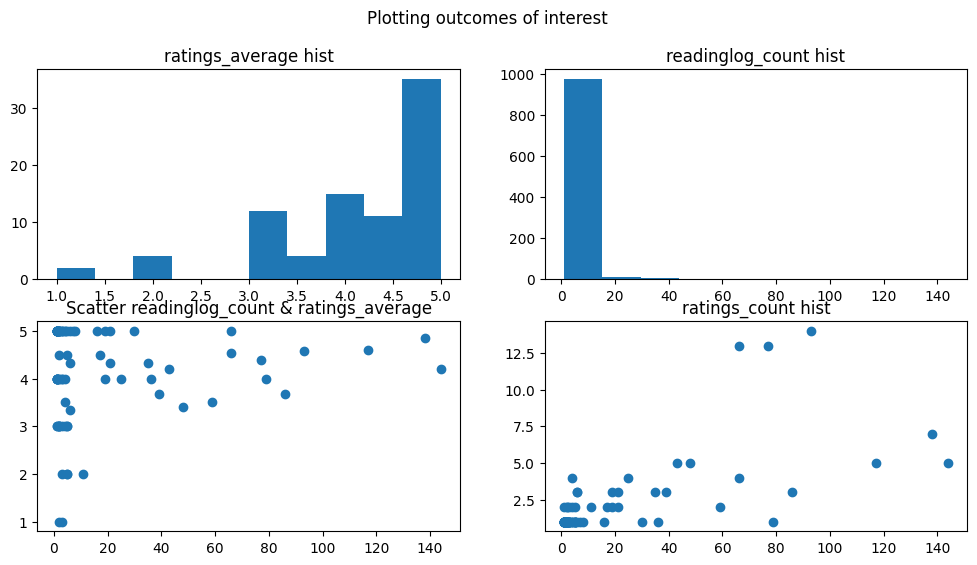

In [44]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs[0,0].set_title('ratings_average hist')
axs[0,0].hist(data_df['ratings_average'])
axs[0,1].set_title('readinglog_count hist')
axs[0,1].hist(data_df['readinglog_count'])
axs[1,0].set_title('Scatter readinglog_count & ratings_average')
axs[1,0].scatter(data_df['readinglog_count'], data_df['ratings_average'])
axs[1,1].set_title('ratings_count hist')
axs[1,1].scatter(data_df['readinglog_count'], data_df['ratings_count'])
fig.suptitle('Plotting outcomes of interest')


A quick look at the relationship between our two outcomes of interest, readinglog_count and ratings_average, appears to tell us the following:
- The 

(array([ 3.,  3., 23., 31., 10.,  5.,  4.,  0.,  1.,  3.]),
 array([1.736997  , 1.93716803, 2.13733906, 2.33751009, 2.53768112,
        2.73785215, 2.93802318, 3.13819421, 3.33836524, 3.53853627,
        3.7387073 ]),
 <BarContainer object of 10 artists>)

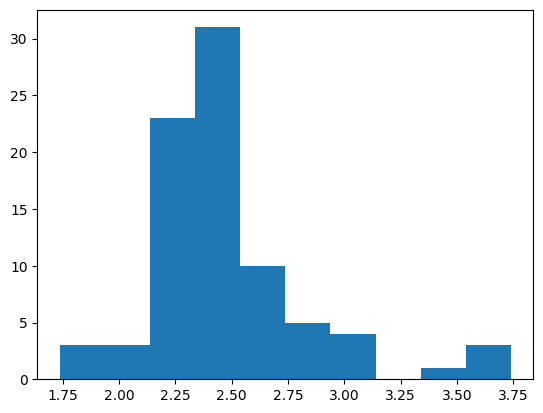

In [45]:
plt.hist(data_df['ratings_sortable'])


Let's clean up the data that we queried for further analysis:
- Null data
- Duplicates
- Outliers
- Scaling Numerical features
- Balancing
- Encoding categorical features

In [49]:
# Check for missing / null data
data_df.isnull().sum().sort_values(ascending=False) / len(data_df)

first_sentence             0.994
ratings_average            0.917
ratings_sortable           0.917
ratings_count              0.917
subject                    0.590
format                     0.547
language                   0.356
number_of_pages_median     0.309
author_name                0.016
publisher                  0.003
first_publish_year         0.000
title                      0.000
readinglog_count           0.000
want_to_read_count         0.000
currently_reading_count    0.000
already_read_count         0.000
dtype: float64

Conclusion: ~92% of entries are missing ratings data. Meaning that only 8% of books that are read get rated by users.

In [57]:
# Duplicates

# Since it is possible to have the same title for different books AND for one author to have published multiple books, let's
# create a composite column of 'title by author_name'
data_df['title_author'] = data_df.apply(lambda row: f"{row['title']} by {row['author_name']}", axis=1)
#print(data_df[['title', 'author_name', 'title_author']].head())

# check duplicates using this composite column 'title_author' compared to others
print(f"Duplicates: title_author: {data_df['title_author'].duplicated().sum()} vs title: {data_df['title'].duplicated().sum()} vs author: {data_df['author_name']}.")

Duplicates: title_author: 0 vs title: 0 vs author: 0                                                [Kamal]
1                                  [Adrian Langenscheid]
2      [Neil Alexander Campbell, Jane B. Reece, Lisa ...
3                                [Theodoros Mavrojannis]
4                                       [Hunter, Robert]
                             ...                        
995                                         [Lexy Timms]
996                                        [Eric Firley]
997                                     [Harry Freedman]
998                      [Margarita Engle, Rafael López]
999    [Josi S. Kilpack, Heather B. Moore, Julie Daines]
Name: author_name, Length: 1000, dtype: object.


No duplicates, awesome.

<Axes: >

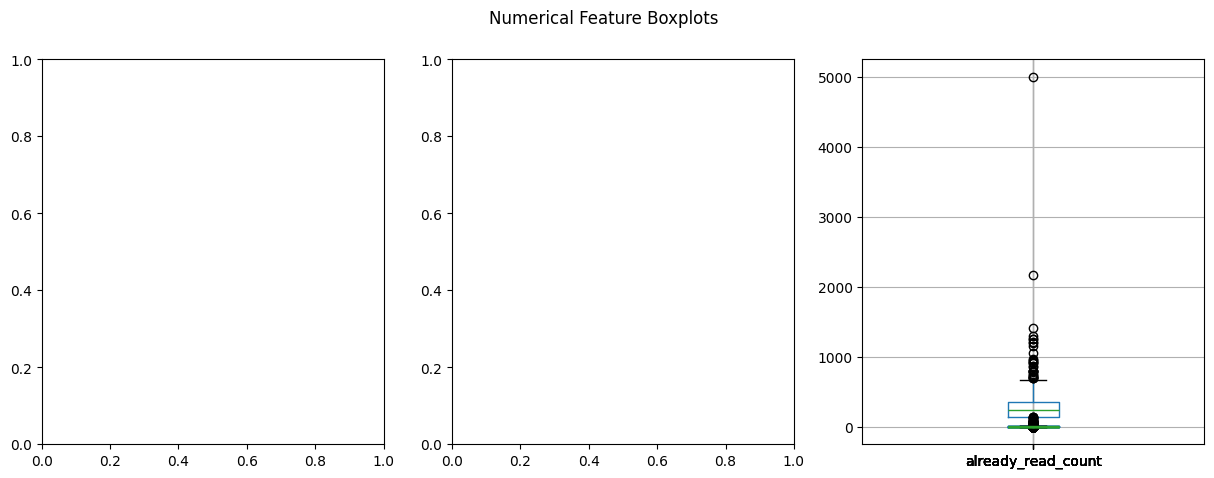

In [68]:
# Outliers
#fig, axes = plt.subplots(0, 0, figsize=(15, 5))
#fig.suptitle('Numerical Feature Boxplots')
data_df[['number_of_pages_median']].boxplot()
axes[0].set_title('number_of_pages_median')

#data_df[['ratings_average']].boxplot()
#axes[1].set_title('ratings_average')
#data_df[['ratings_count']].boxplot()
#axes[2].set_title('ratings_count')
#data_df[['readinglog_count']].boxplot()
#axes[3].set_title('readinglog_count')
#data_df[['want_to_read_count']].boxplot()
#axes[4].set_title('want_to_read_count')
#data_df[['currently_reading_count']].boxplot()
#axes[5].set_title('currently_reading_count')
#data_df[['already_read_count']].boxplot()
#axes[6].set_title('already_read_count')


#'number_of_pages_median,publisher,format,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,first_sentence',


Moving forward, let's first consider each of the following separately: 
1. What book features positively influence ratings from readers?
2. What book features positively influence reading count from readers?
3. How do these features impact ratings_sortable? A feature that combines and weighs the ratings outcome by the number of ratings?
4. 

In [ ]:
import seaborn as sns

# Correlation
sns.heatmap(round(data_df.corr(),2), ax=axes[0], cmap = "coolwarm", annot = True)
axes[0].set_title('Correlation of numeric cols')